<a href="https://colab.research.google.com/github/rivanachristie/starcraft_player_performance/blob/main/Starcraft_Player_Performance_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starcraft Player Dataset

The Starcraft player dataset contains player performance data in ranked games. In this notebook, we will explore the player performance wrt their league, perform feature selection and finally, train different models to predict the league index for the user that played the given game. The following models are used to predict the league index:
1. Decision Tree
2. Random Forest
3. LightGBM
4. Feedforward Neural Network

##1. Loading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential 
from keras import Input 
from keras.layers import Dense
from lightgbm import early_stopping, log_evaluation
import lightgbm as lgb

%matplotlib inline

In [2]:
# Reading the dataset
df = pd.read_csv('starcraft_player_data.csv')

In [3]:
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


The dataset has 3395 records with 20 features for each record.

In [4]:
df.shape

(3395, 20)

##2. Data Cleaning 

Now, let us examine the dataset in more detail. Looking at the datatypes for the columns in the dataset, we can see that 'Age', 'HoursPerWeek' and 'TotalHours' are of type 'object'. However, these are numerical fields. So, will convert them to 'float'.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3395 non-null   object 
 3   HoursPerWeek          3395 non-null   object 
 4   TotalHours            3395 non-null   object 
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

Converting the data type of columns 'Age', 'HoursPerWeek' and 'TotalHours' from object to float. Looking at the unique values for each of these three columns, we see that there are values with '?'. So, we will replace '?' with NaN.

In [6]:
df['TotalHours'].unique()

array(['3000', '5000', '200', '400', '500', '70', '240', '10000', '2708',
       '800', '6000', '190', '350', '1000', '1500', '2000', '120', '1100',
       '2520', '700', '160', '150', '250', '730', '230', '300', '100',
       '270', '1200', '30', '600', '540', '280', '1600', '50', '140',
       '900', '550', '625', '1300', '450', '750', '612', '180', '770',
       '720', '415', '1800', '2200', '480', '430', '639', '360', '1250',
       '365', '650', '233', '416', '1825', '780', '1260', '315', '10',
       '312', '110', '1700', '92', '2500', '1400', '220', '999', '303',
       '96', '184', '4000', '420', '60', '2400', '2160', '80', '25',
       '624', '176', '?', '35', '1163', '333', '75', '7', '40', '325',
       '90', '175', '88', '850', '26', '1650', '465', '235', '1350',
       '460', '848', '256', '130', '1466', '670', '711', '1030', '1080',
       '1460', '1050', '20000', '582', '2800', '553', '1008', '330',
       '936', '243', '1320', '425', '1145', '366', '2700', '830', '3',
 

In [7]:
df['HoursPerWeek'].unique()

array(['10', '20', '6', '8', '42', '14', '24', '16', '4', '12', '30',
       '28', '70', '2', '56', '36', '40', '18', '96', '50', '168', '48',
       '84', '0', '72', '112', '90', '32', '98', '140', '?', '80', '60'],
      dtype=object)

In [8]:
df['Age'].unique()

array(['27', '23', '30', '19', '32', '21', '17', '20', '18', '16', '26',
       '38', '28', '25', '22', '29', '24', '35', '31', '33', '37', '40',
       '34', '43', '41', '36', '44', '39', '?'], dtype=object)

In [9]:
# Replacing '?' with NaN
df['TotalHours'] = df['TotalHours'].replace('?', np.nan)
df['HoursPerWeek'] = df['HoursPerWeek'].replace('?', np.nan)
df['Age'] = df['Age'].replace('?', np.nan)

In [10]:
# Converting columns to float
df = df.astype({'TotalHours': 'float',
                'HoursPerWeek': 'float',
                'Age': 'float'})

##3. Exploratory Data Analysis (EDA)

First of all, let us look at the number of games by League Index.

In [11]:
# Defining league labels and creating a dictionary
league_labels = ["Bronze", "Silver", "Gold", "Platinum", "Diamond", "Master", 
                 "Grandmaster", "Professional"]
league_index = [i for i in range(1, 9)]
league_dict = dict()

for i, idx in enumerate(league_index):
  league_dict[idx] = league_labels[i]
print(league_dict)

{1: 'Bronze', 2: 'Silver', 3: 'Gold', 4: 'Platinum', 5: 'Diamond', 6: 'Master', 7: 'Grandmaster', 8: 'Professional'}


In [12]:
# Function to get colors for plots
def get_colors(cmp, vars):
  cmap = plt.get_cmap(cmp)
  colors = []

  for i in range(len(vars)):
    colors.append(cmap(i/len(vars)))
  
  return colors

From the plot below, we can see that players in the Platinum league played the highest number of games, followed by Diamond. Very few games were played by players in the Grandmaster and Professional leagues.

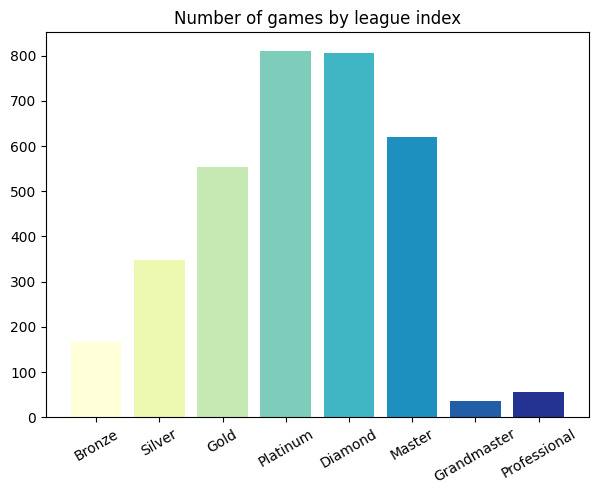

In [13]:
# Visualizing the number of games by league label
lg_colors = get_colors('YlGnBu', league_index)

league_df = df[['LeagueIndex','GameID']].groupby('LeagueIndex').count().reset_index()

fig = plt.figure(figsize=(7, 5))

plt.bar(league_df['LeagueIndex'], league_df['GameID'], color=lg_colors)
plt.xticks(league_df['LeagueIndex'], labels=league_labels, rotation=30)
plt.title('Number of games by league index')
plt.show()

In [14]:
# Function to plot a scatter plot for a feature vs league index
def plot_scatter(col):
  plt.figure(figsize=(15, 5))
  plt.subplot(1,2,1)
  plt.scatter(df['LeagueIndex'], df[col])
  plt.xticks(league_df['LeagueIndex'], labels=league_labels, rotation=30)

  plt.subplot(1,2,2)
  sns.boxplot(data=df, x='LeagueIndex', y=col, palette='husl')
  plt.xticks(league_df['LeagueIndex']-1, labels=league_labels, rotation=30)
  plt.show()

Now, we will visualize the total number of hours spent playing vs the league index. As we can see in the plot, there is an outlier that is heavily skewing data. So, we will handle this outlier in the data preprocessing.

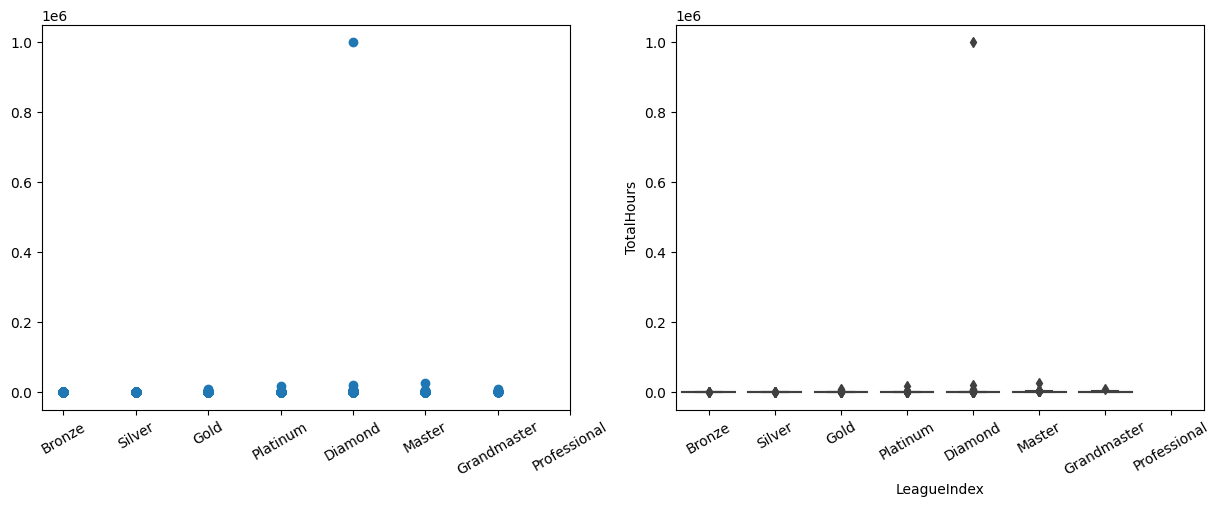

In [15]:
plot_scatter('TotalHours')

Looking at the visualization for actions per minute, we again see an increasing trend where players in the professional leagues had the highest number of actions per minute. However, we do see some outliers in the other leagues too. But generally, we can conclude that the higher the number of actions per minute, the more experienced the player is.

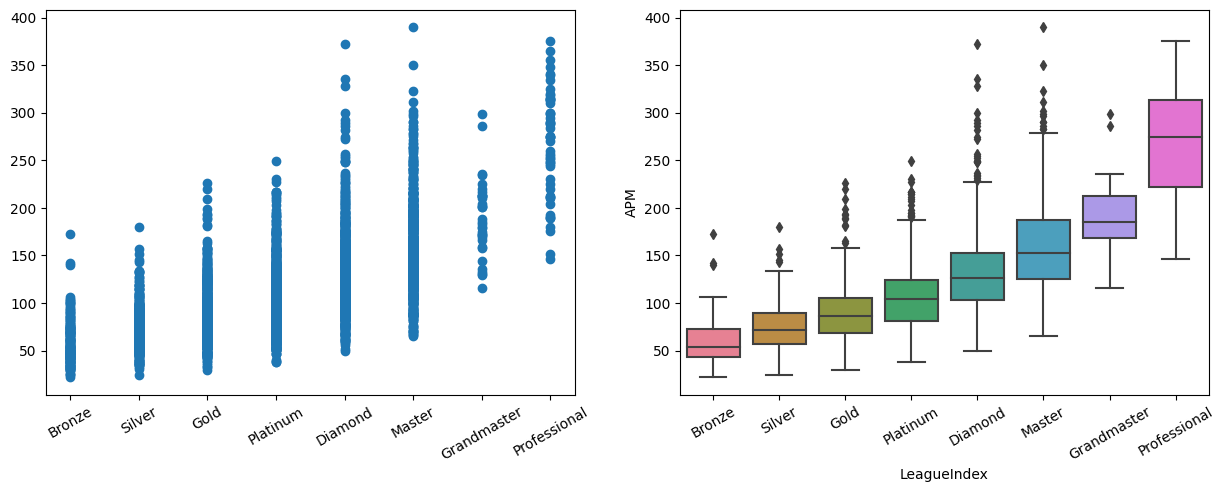

In [16]:
plot_scatter('APM')

Now, looking at the visualization for action latency, we see a steady downward trend, indicating that the more experienced the player is, the lower is the reaction time. 

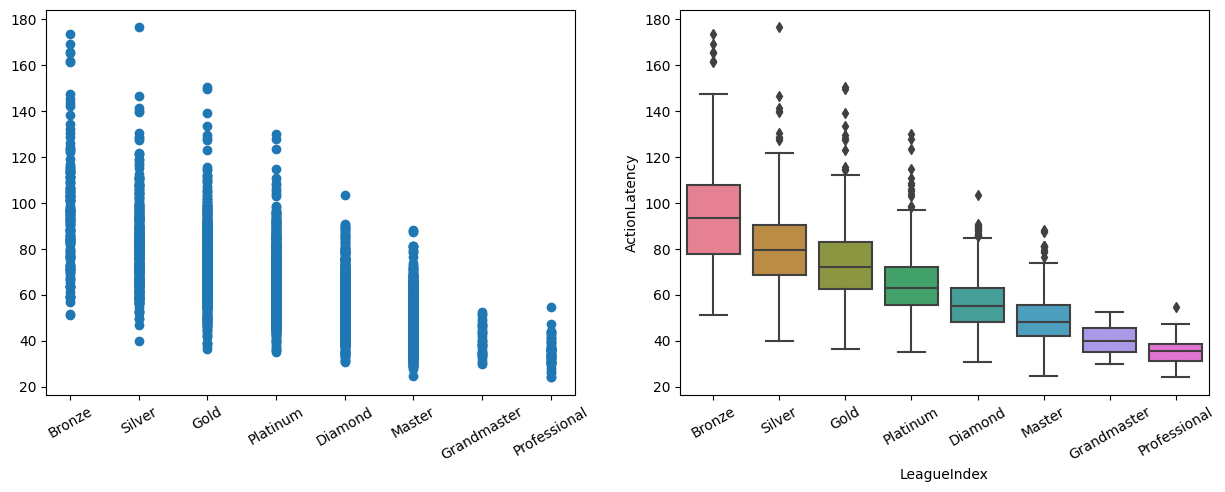

In [17]:
plot_scatter('ActionLatency')

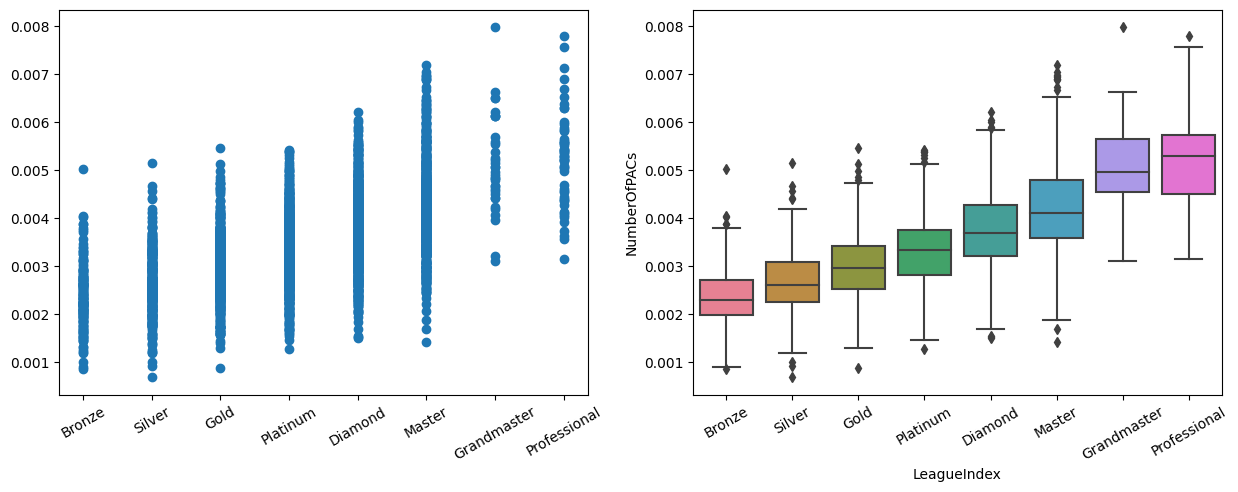

In [18]:
plot_scatter('NumberOfPACs')

##4. Data Preprocessing

As part of data preprocessing, we will first examine the statistical distribution of each column in the dataset, and then we will handle missing values and outliers using statistical methods. From the distribution, we can see that while some columns are fairly distributed with a lower number of outliers, there are some columns that are highly skewed. 

In [19]:
df.describe([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3395.000000,3395.000000,3340.000000,3339.000000,3338.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000,3395.000000
mean,4805.012371,4.184094,21.647904,15.910752,960.421809,117.046947,0.004299,0.000374,4.364654,0.000098,0.000387,0.003463,40.361562,63.739403,5.272988,22.131664,0.001032,6.534021,0.000059,0.000142
std,2719.944851,1.517327,4.206341,11.962912,17318.133922,51.945291,0.005284,0.000225,2.360333,0.000166,0.000377,0.000992,17.153570,19.238869,1.494835,7.431719,0.000519,1.857697,0.000111,0.000265
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
0%,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.093600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2464.500000,3.000000,19.000000,8.000000,300.000000,79.900200,0.001258,0.000204,3.000000,0.000000,0.000140,0.002754,28.957750,50.446600,4.272850,17.000000,0.000683,5.000000,0.000000,0.000000
50%,4874.000000,4.000000,21.000000,12.000000,500.000000,108.010200,0.002500,0.000353,4.000000,0.000040,0.000281,0.003395,36.723500,60.931800,5.095500,22.000000,0.000905,6.000000,0.000000,0.000020
75%,7108.500000,5.000000,24.000000,20.000000,800.000000,142.790400,0.005133,0.000499,6.000000,0.000119,0.000514,0.004027,48.290500,73.681300,6.033600,27.000000,0.001259,8.000000,0.000086,0.000181
90%,8481.200000,6.000000,27.000000,28.000000,1200.000000,184.620120,0.009832,0.000647,7.000000,0.000261,0.000841,0.004755,61.612040,88.730580,7.030980,31.000000,0.001701,9.000000,0.000221,0.000423
95%,8978.300000,6.000000,29.000000,40.000000,1566.000000,212.236200,0.014712,0.000757,8.000000,0.000395,0.001110,0.005267,71.807030,97.955680,7.759650,35.000000,0.002043,10.000000,0.000298,0.000625


The 'TotalHours' column has one outlier with value 1000000 that is heavily skewing the data. So, we will first manually set its value to the 99th percentile for 'TotalHours' to balance the data a bit.

In [20]:
df.loc[df['TotalHours'] > df['TotalHours'].describe([0.99])['99%'], 'TotalHours'] = df['TotalHours'].describe([0.99])['99%']
df['TotalHours'].describe()

count    3338.000000
mean      629.901138
std       484.925850
min         3.000000
25%       300.000000
50%       500.000000
75%       800.000000
max      2520.000000
Name: TotalHours, dtype: float64

After removing the extreme outlier in 'TotalHours', we can visualize the distribution. We can see that there is an upward increasing trend, in that as the number of hours spent playing increases, the level of expertise of the player also increases. Although, we do not have enough information about players in the Professional leagues, we can assume that those players would have the highest total hours.

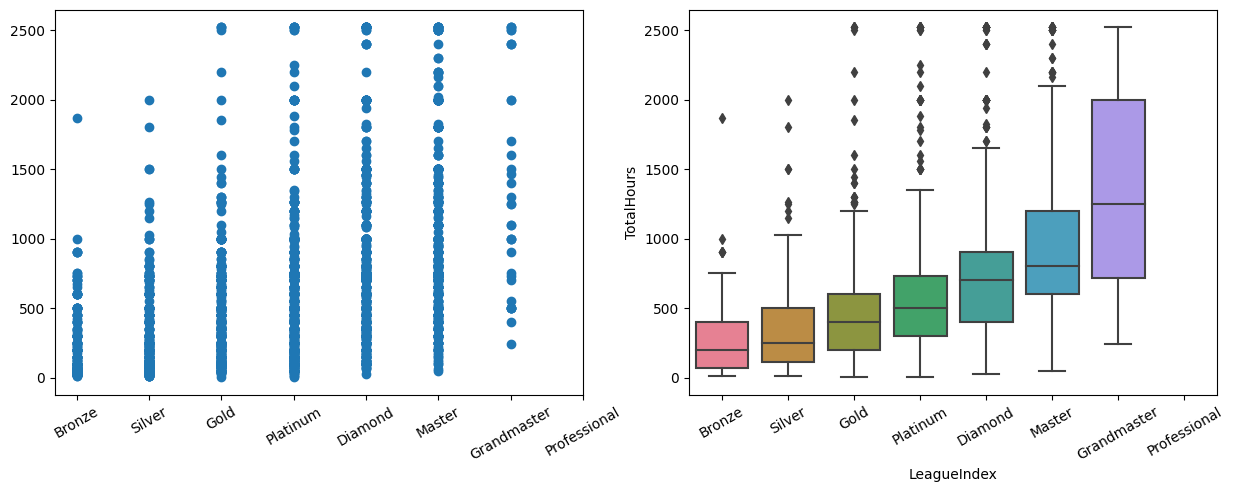

In [21]:
plot_scatter('TotalHours')

In [22]:
df.isna().sum().sum()

168

There are a total of 168 NaN values in the dataset. Looking at the records where 'Age' is NaN, we can see that the 'HoursPerWeek' and 'TotalHours' are also NaN. And surprisingly, all of these games were played by Professional players with 'LeagueIndex'=8. Now, if we decide to drop these records, we will not have enough information about Professional league players. So, we can handle these records by imputing with NaN values with either the 50th, 75th or 99th percentile values.

In [23]:
df.loc[df['Age'].isna()]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3340,10001,8,NaN,NaN,NaN,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.000000
3341,10005,8,NaN,NaN,NaN,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.000000
3342,10006,8,NaN,NaN,NaN,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.000000
3343,10015,8,NaN,NaN,NaN,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.000000
3344,10016,8,NaN,NaN,NaN,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.000000
3345,10017,8,NaN,NaN,NaN,245.8188,0.010471,0.000841,10,0.000657,0.001314,0.005031,14.5518,36.7134,7.1943,33,0.001474,11,0.000040,0.000048
3346,10018,8,NaN,NaN,NaN,211.0722,0.013049,0.000940,10,0.000366,0.000909,0.003719,19.6169,38.9326,7.1320,23,0.000898,9,0.000000,0.000000
3347,10021,8,NaN,NaN,NaN,189.5778,0.007559,0.000487,10,0.000606,0.000566,0.005821,22.0317,36.7330,4.9050,28,0.000540,5,0.000000,0.000000
3348,10022,8,NaN,NaN,NaN,210.5088,0.007974,0.000867,7,0.000548,0.000638,0.006518,15.7856,30.7156,4.8058,34,0.000817,6,0.000000,0.000000
3349,10023,8,NaN,NaN,NaN,248.0118,0.014722,0.001752,7,0.000375,0.000110,0.004115,17.4656,34.2357,7.8973,20,0.001111,8,0.000000,0.000000


Looking at the statistical distribution for games played by players with 'LeagueIndex'=7, we can see that the 50th percentile for 'Age' is 22; and 95th percentile for 'HoursPerWeek' and 'TotalHours' are 56 and 2520 respectively. We will use these values to impute the dataset for players with 'LeagueIndex'=8.

In [24]:
df.loc[df['LeagueIndex'] == 7].describe([0.75, 0.95, 0.99])

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,35.000000,35.0,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,4683.771429,7.0,21.171429,31.714286,1348.457143,189.555686,0.009418,0.000723,6.771429,0.000340,0.000570,0.005111,22.978160,40.342903,5.226089,28.028571,0.001238,7.028571,0.000082,0.000267
std,2867.112732,0.0,2.864444,20.626327,755.354858,40.792493,0.004987,0.000277,1.699234,0.000304,0.000392,0.000997,6.157568,6.490887,1.078309,8.114931,0.000697,1.901790,0.000125,0.000588
min,72.000000,7.0,16.000000,6.000000,240.000000,115.755600,0.002693,0.000310,4.000000,0.000010,0.000025,0.003108,10.285700,29.987100,3.322100,14.000000,0.000484,3.000000,0.000000,0.000000
50%,4754.000000,7.0,22.000000,28.000000,1250.000000,185.342400,0.008216,0.000698,7.000000,0.000241,0.000513,0.004952,22.485500,39.731300,5.306200,28.000000,0.001009,7.000000,0.000000,0.000040
75%,7336.500000,7.0,23.000000,42.000000,2000.000000,212.375100,0.011948,0.000894,8.000000,0.000394,0.000780,0.005636,26.431800,45.726300,6.074400,33.000000,0.001429,8.000000,0.000121,0.000235
95%,8861.400000,7.0,25.300000,56.000000,2520.000000,251.158260,0.016493,0.001252,10.000000,0.000952,0.001310,0.006534,33.315440,51.468000,6.928090,38.700000,0.002696,10.000000,0.000331,0.001243
99%,9166.640000,7.0,26.000000,83.720000,2520.000000,294.599124,0.023738,0.001367,10.000000,0.001138,0.001532,0.007510,37.391554,52.131308,7.182340,50.280000,0.003065,10.660000,0.000374,0.002526
max,9202.000000,7.0,26.000000,98.000000,2520.000000,298.795200,0.026770,0.001387,10.000000,0.001164,0.001632,0.007971,38.787900,52.311100,7.236400,53.000000,0.003191,11.000000,0.000386,0.002685


In [25]:
# Imputing missing values based on percentiles
vals = df.loc[df['LeagueIndex'] == 7].describe([0.75, 0.95, 0.99])
df.loc[df['LeagueIndex'] == 8, ['TotalHours', 'Age', 'HoursPerWeek']] = [vals['TotalHours']['95%'],
                                                                         vals['Age']['50%'],
                                                                         vals['HoursPerWeek']['95%']]

In [26]:
df.loc[df['LeagueIndex'] == 8].head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3340,10001,8,22.0,56.0,2520.0,189.7404,0.004582,0.000655,4,0.000073,0.000618,0.006291,23.5130,32.5665,4.4451,25,0.002218,6,0.000000,0.0
3341,10005,8,22.0,56.0,2520.0,287.8128,0.029040,0.001041,9,0.000231,0.000656,0.005399,31.6416,36.1143,4.5893,34,0.001138,6,0.000058,0.0
3342,10006,8,22.0,56.0,2520.0,294.0996,0.029640,0.001076,6,0.000302,0.002374,0.006294,16.6393,36.8192,4.1850,26,0.000987,6,0.000000,0.0
3343,10015,8,22.0,56.0,2520.0,274.2552,0.018121,0.001264,8,0.000053,0.000975,0.007111,10.6419,24.3556,4.3870,28,0.001106,6,0.000000,0.0
3344,10016,8,22.0,56.0,2520.0,274.3404,0.023131,0.000739,8,0.000622,0.003552,0.005355,19.1568,36.3098,5.2811,28,0.000739,6,0.000000,0.0


Now, we have significantly reduced the number of NaN values and we drop the remaining records that contain NaN values.

In [27]:
df[df.isna().any(axis=1)]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
358,1064,5,17.0,20.0,NaN,94.4724,0.003846,0.000783,3,0.000010,0.000135,0.004474,50.5455,54.9287,3.0972,31,0.000763,7,0.000106,0.000116
1841,5255,5,18.0,NaN,NaN,122.2470,0.006357,0.000433,3,0.000014,0.000257,0.003043,30.8929,62.2933,5.3822,23,0.001055,5,0.000000,0.000338


In [28]:
df.isna().sum().sum()

3

In [29]:
print(f'Length of original dataset: {len(df)}')
new_df = df.dropna()
print(f'Length of dataset after dropping null values: {len(new_df)}')

Length of original dataset: 3395
Length of dataset after dropping null values: 3393


To further preprocess the dataset, let us remove the 'GameID' as it is the unique identifier and does not influence the features.

In [30]:
# Removing 'GameID'
new_df = new_df.drop('GameID', axis=1)

As we can see from the histograms below, all of the columns have a lot of outliers. So firstly, we would need to remove outliers and standardize the data so that it can be used for further data modeling.

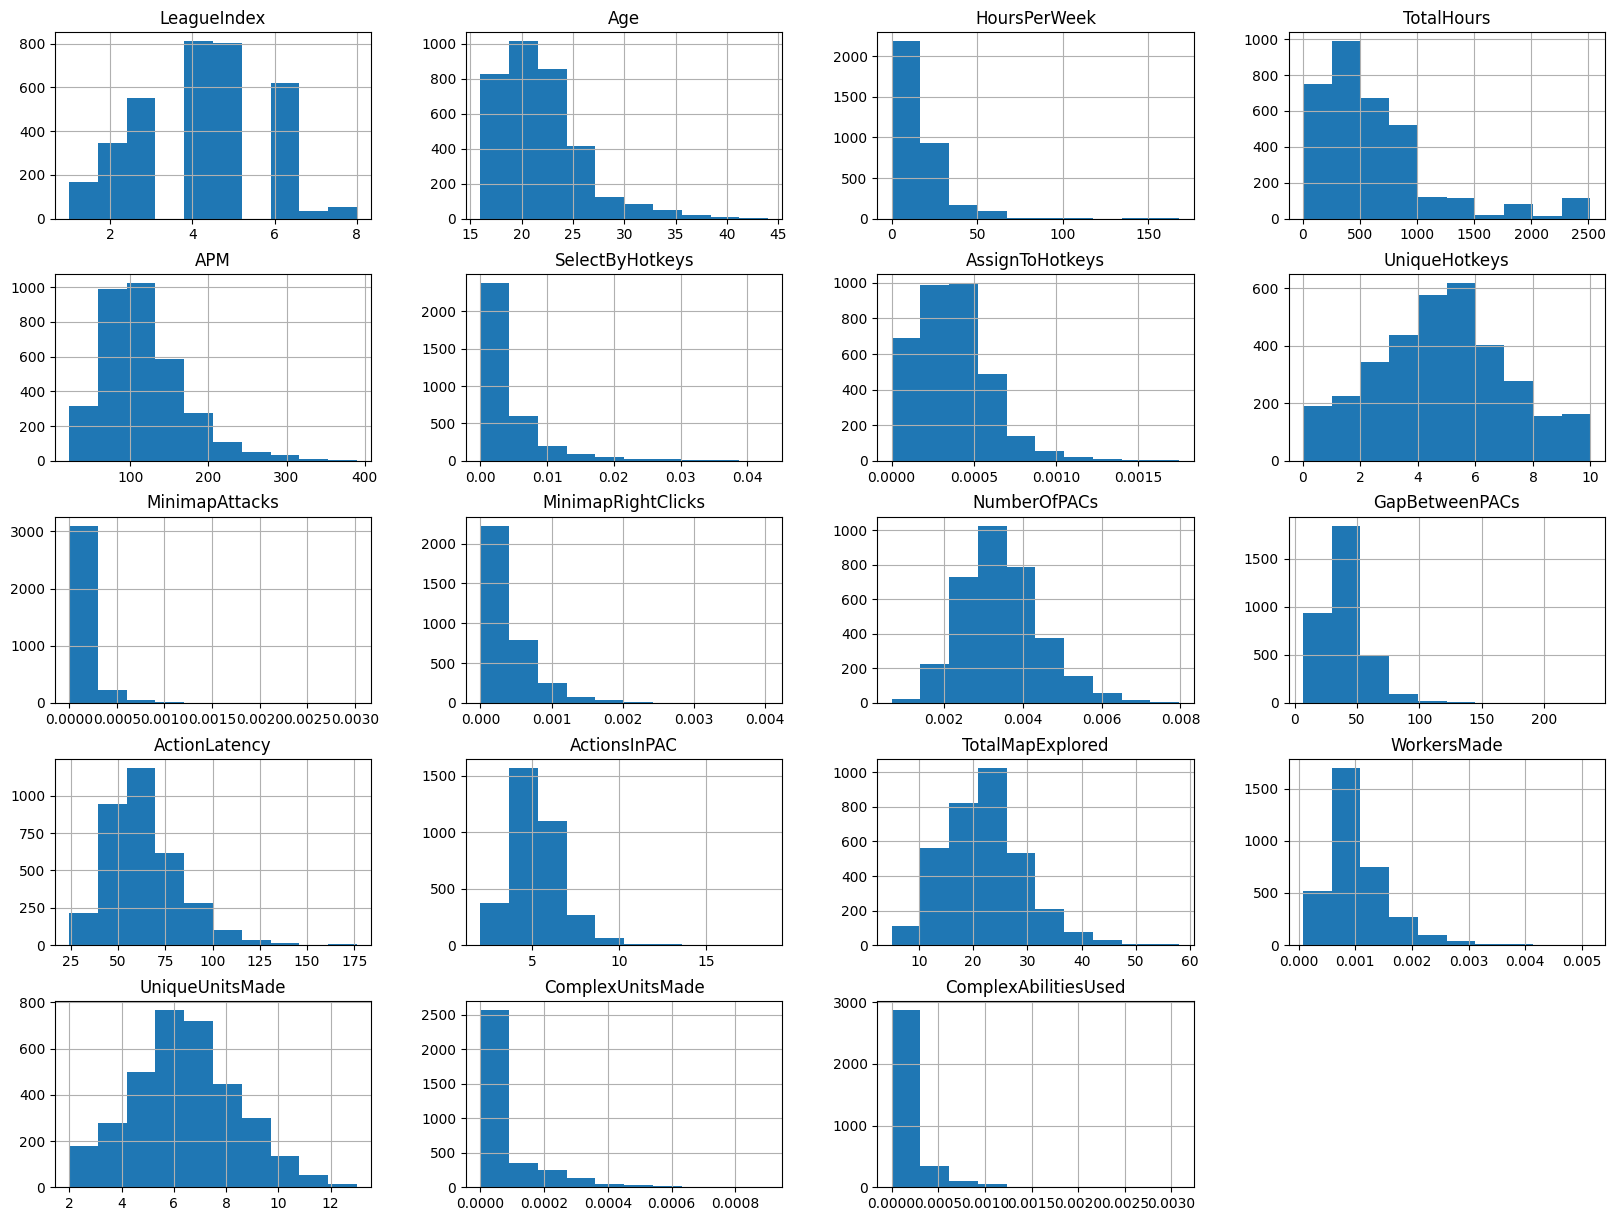

In [31]:
# Plotting a histogram for each column in the dataset
new_df.hist(figsize=(20, 15));

Now, we need to transform all the skewed columns to ensure that the data is fairly distributed and does not have outliers.

In [32]:
# Getting the names of all skewed columns
skewed_cols = [col for col in new_df.columns if col not in ['LeagueIndex']]
skewed_cols

['Age',
 'HoursPerWeek',
 'TotalHours',
 'APM',
 'SelectByHotkeys',
 'AssignToHotkeys',
 'UniqueHotkeys',
 'MinimapAttacks',
 'MinimapRightClicks',
 'NumberOfPACs',
 'GapBetweenPACs',
 'ActionLatency',
 'ActionsInPAC',
 'TotalMapExplored',
 'WorkersMade',
 'UniqueUnitsMade',
 'ComplexUnitsMade',
 'ComplexAbilitiesUsed']

In [33]:
transformed_df = new_df

We will now apply log transformation to handle the outliers and transform the dataset.

In [34]:
# Applying log transformation
for col in skewed_cols:
  transformed_df[col] = np.log1p(transformed_df[col])

From the histograms below, we can see that the columns are now more distributed.

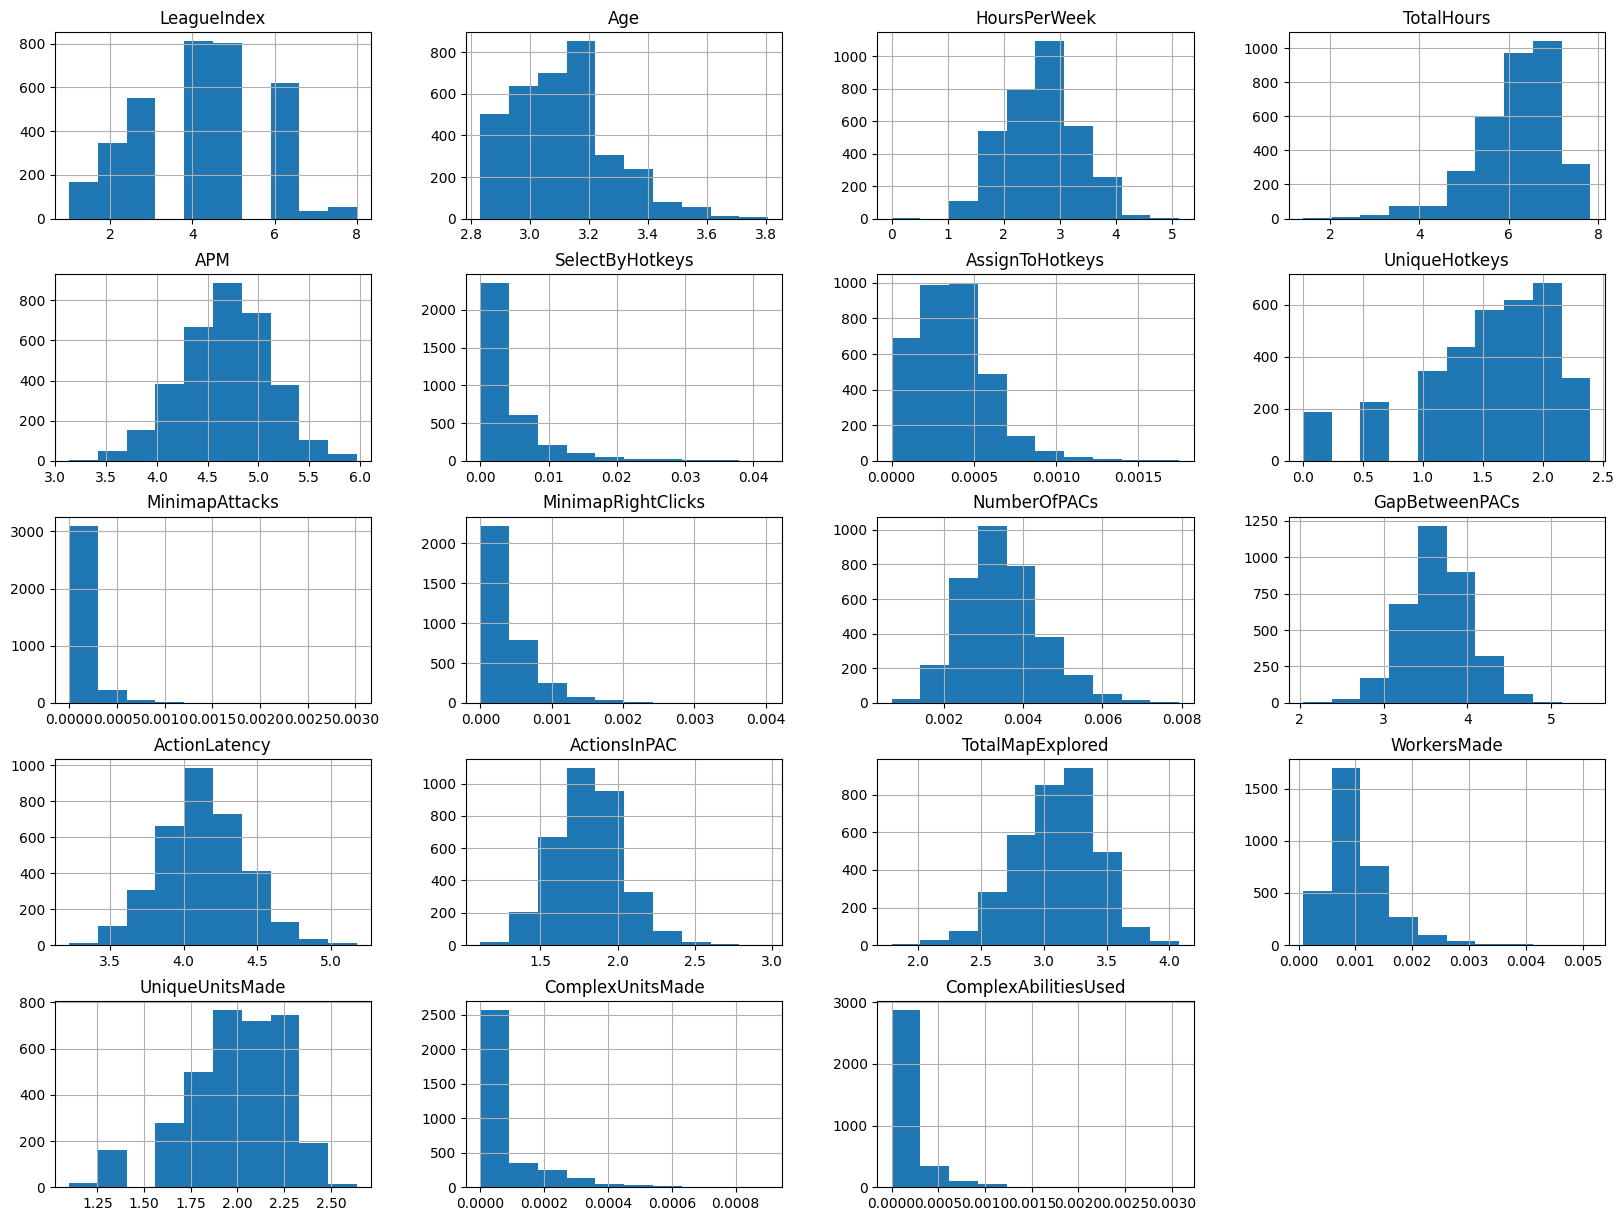

In [35]:
# Visualizing the histograms after transformation
transformed_df.hist(figsize=(20, 15));

We will now plot a heatmap to visualize the correlation between the columns of the dataset. From the heatmap, we can see that Action Per Minute (APM), Number of PACs and AssignToHotKeys have the highest correlation with LeagueIndex, followed by SelectByHotKeys.

<Axes: >

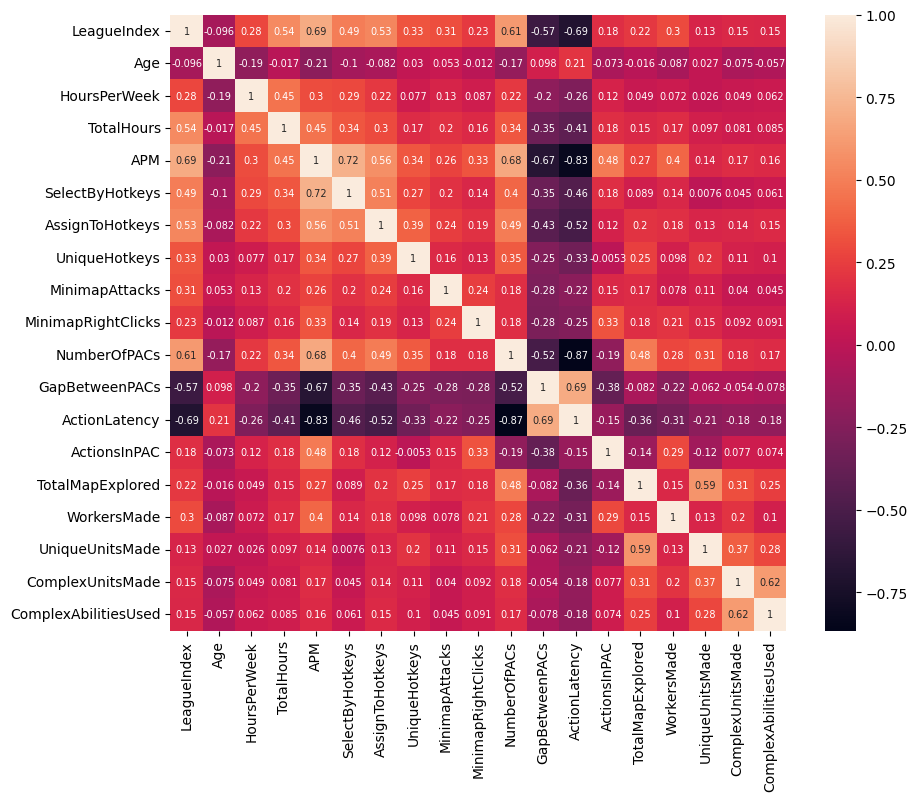

In [36]:
# Plotting a heatmap to visualize correlation between columns
corr_matrix = transformed_df.corr()
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, square=True, annot=True, annot_kws={"fontsize":7})

Since we are trying to predict the 'LeagueIndex', we can also remove that from the dataset and save it as the target variable.

In [37]:
# Setting 'LeagueIndex' as the target variable
target_variable = transformed_df['LeagueIndex']
transformed_df = transformed_df.drop('LeagueIndex', axis=1)

We will now scale the data using Standard, so that the data will be standardized.

In [38]:
# Function to apply the scaler and return the scaled dataframe
def scale_data(data):
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(data)
  scaled_data_df = pd.DataFrame(scaled_data, columns=data.columns)
  return scaled_data_df

In [39]:
scaled_df = scale_data(transformed_df)

Now that the dataset is fairly distributed and scaled, we will now perform feature selection based on their importance. We will select the k features that influence the league index.

In [40]:
# Function to select k best features
def select_features(df, target, k):
  kbest = SelectKBest(k=k)
  kbest.fit(df, target_variable)
  features = np.argsort(kbest.scores_)[::-1]
  return pd.DataFrame({"features": df.columns[features].values, 
                      "scores": kbest.scores_[features]})

<BarContainer object of 18 artists>

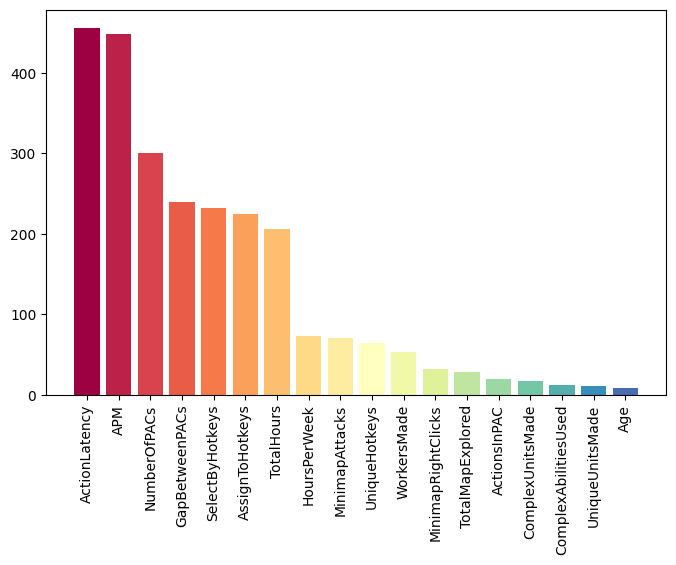

In [41]:
# Getting the dataframe with features ranked by importance
features_df = select_features(scaled_df, target_variable, 10)

fcolors = get_colors('Spectral', features_df)

# Visualizing the features ranked by their importance
plt.figure(figsize=(8, 5))
plt.xticks(rotation=90)
plt.bar(features_df['features'], features_df['scores'], color=fcolors)

From the above plot, we can observe that 7 features have the highest scores and the features following these have a significantly lower score.

In [42]:
# Selecting features with the highest scores
selected_features = features_df['features'][:7]
selected_features

0      ActionLatency
1                APM
2       NumberOfPACs
3     GapBetweenPACs
4    SelectByHotkeys
5    AssignToHotkeys
6         TotalHours
Name: features, dtype: object

In [43]:
# Creating a dataframe with the selected features
subset_df = scaled_df[[*selected_features]]
subset_df.head()

,ActionLatency,APM,NumberOfPACs,GapBetweenPACs,SelectByHotkeys,AssignToHotkeys,TotalHours
0,-1.386864,0.683153,1.397044,-0.340875,-0.146735,-0.683760,1.830930
1,-1.265002,0.439313,0.851303,-0.321477,-0.187068,-0.506869,1.830930
2,0.723645,-0.964492,-0.540943,0.451903,-0.607942,-0.168320,-0.927048
3,-0.445553,0.019380,0.322863,-0.622205,-0.620863,-0.713103,-0.173891
4,0.052907,0.323902,-1.103356,-1.256418,-0.601262,-0.204993,0.068902


In [44]:
# Splitting the dataframe into train and test sets
x_train, x_test, y_train, y_test = train_test_split(subset_df, target_variable, 
                                                    random_state=13, test_size=0.2)

In [45]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2714, 7)
(2714,)
(679, 7)
(679,)


##5. Data Modeling

###Decision Tree

In [46]:
# Function to implement a decision tree model with grid search CV
def decision_tree_model(max_depth, min_split, train_x, train_y):
  params = {'max_depth': max_depth, 'min_samples_split':min_split}
  clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params,
                     n_jobs=-1, scoring='accuracy', verbose=1)
  clf.fit(train_x, train_y)
  return clf

In [47]:
# Function to run the decision tree model
def run_decision_tree(x_train, y_train, x_test, y_test):
  max_depth = [i for i in range(5, 15)]
  min_split = [i for i in range(2, 15)]
  dt_model = decision_tree_model(max_depth, min_split, x_train, y_train)

  print(f'Scoring function: {dt_model.scorer_}')
  print(f'Train accuracy: {round(dt_model.best_score_ * 100, 2)}%')
  
  y_pred = dt_model.predict(x_test)
  print(f'Test accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)}%')

In [48]:
run_decision_tree(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 130 candidates, totalling 650 fits
Scoring function: make_scorer(accuracy_score)
Train accuracy: 38.03%
Test accuracy: 36.67%


For the Decision Tree model, we get 36.67% test accuracy and 38.03% training accuracy. While the model accuracy if fairly low, there is little difference between the train and test accuracies. So, we can say that the model is not overfitting.

###Random Forest

In [49]:
# Function to implement the random forest model
def random_forest_model(x_train, y_train, x_test, y_test):
  rfc = RandomForestClassifier(n_estimators=20, max_depth=5, min_samples_split=2, 
                               random_state=13, criterion='gini', bootstrap=True, 
                               n_jobs=-1)
  rfc.fit(x_train, y_train)
  rfc_train_pred = rfc.predict(x_train)
  rfc_pred = rfc.predict(x_test)
  
  print(f'Train accuracy: {round(accuracy_score(y_train, rfc_train_pred) * 100, 2)}%')
  print(f'Test accuracy: {round(accuracy_score(y_test, rfc_pred) * 100, 2)}%')

In [50]:
random_forest_model(x_train, y_train, x_test, y_test)

Train accuracy: 48.16%
Test accuracy: 40.21%


Using the Random Forest model, we get a little higher accuracy with test accuracy as 40.21% and training accuracy at 48.16%. We do see some difference in the train and test accuracies, indicating that the model might be affected a bit by overfitting.

###LightGBM

In [51]:
# Function to implement the LightGBM model
def lgbm_model(x_train, y_train, x_test, y_test):
  lgb_train = lgb.Dataset(x_train, label=y_train)
  lgb_test = lgb.Dataset(x_test, label=y_test)
  
  # Defining the parameters for the lightGBM model
  params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(target_variable))+1,
    'metric': 'multi_logloss',
    'num_leaves': 29,
    'learning_rate': 0.7,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2': 1,
    'verbose': -1
  }

  model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_test],
                  num_boost_round=1000, callbacks=[early_stopping(100), log_evaluation(100)])
  
  lgb_train_pred = model.predict(x_train)
  lgb_train_pred = np.argmax(lgb_train_pred, axis=1)

  lgb_test_pred = model.predict(x_test)
  lgb_test_pred = np.argmax(lgb_test_pred, axis=1)

  print(f'Train accuracy: {round(accuracy_score(y_train, lgb_train_pred) * 100, 2)}%')
  print(f'Test accuracy: {round(accuracy_score(y_test, lgb_test_pred) * 100, 2)}%')

In [52]:
lgbm_model(x_train, y_train, x_test, y_test)

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.00900977	valid_1's multi_logloss: 2.81262
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.31077	valid_1's multi_logloss: 1.52412
Train accuracy: 49.15%
Test accuracy: 35.49%


For the LightGBM model, we get 36.52% accuracy on the test set and 49.52% accuracy on the training set. So, we can say that the model might is overfitting on the training data and it is not able to generalize well on the testing data.

###Feedforward Neural Network

In [53]:
# Function to implement a feedforward neural network
def fnn_model(x_train, y_train, x_test, y_test):
  model = Sequential()
  model.add(Input(shape=x_train.shape[1]))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(len(league_index)+1, activation='softmax'))

  model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test),
          batch_size=32)
  
  return history, model

In [54]:
# Function to plot the accuracy and loss for the FNN
def plot_scores(history):
  plt.figure(figsize=(15, 5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Number of epochs')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label = 'Training Loss')
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.title("Model Loss")
  plt.xlabel('Number of epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [55]:
history, fnn = fnn_model(x_train, y_train, x_test, y_test)

Epoch 1/100
85/85 [==============================] - 1s 4ms/step - loss: 1.9083 - accuracy: 0.3099 - val_loss: 1.6918 - val_accuracy: 0.3270
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5942 - accuracy: 0.3681 - val_loss: 1.5112 - val_accuracy: 0.3579
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 1.4624 - accuracy: 0.3913 - val_loss: 1.4159 - val_accuracy: 0.3888
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 1.3953 - accuracy: 0.3928 - val_loss: 1.3717 - val_accuracy: 0.3976
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 1.3637 - accuracy: 0.3987 - val_loss: 1.3582 - val_accuracy: 0.3976
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 1.3434 - accuracy: 0.4042 - val_loss: 1.3514 - val_accuracy: 0.4109
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 1.3299 - accuracy: 0.4134 - val_loss: 1.3372 - val_accuracy: 0.3962
Epoch 8/100
8

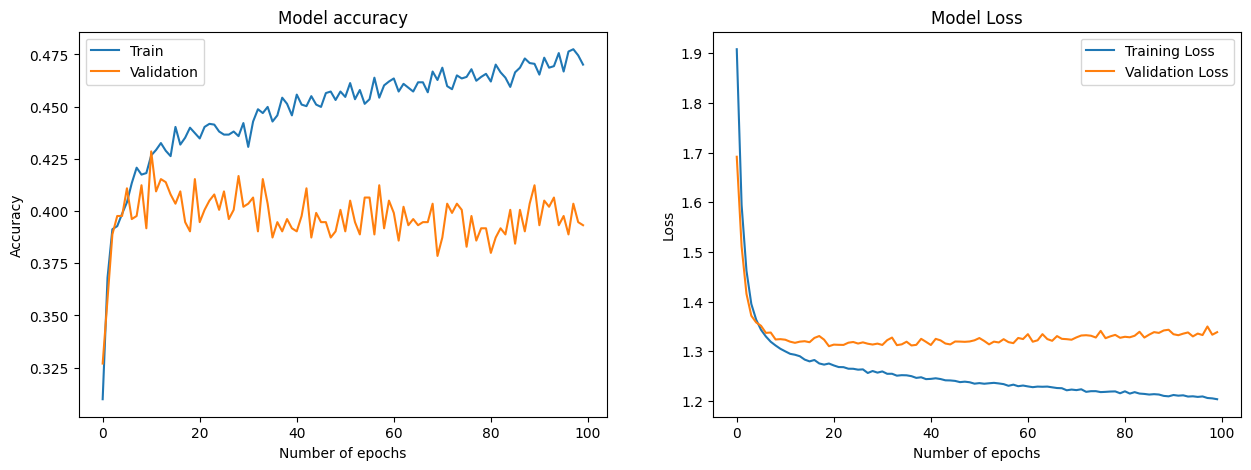

In [56]:
plot_scores(history)

From the plots above, we can see that the highest train and test accuracy are around 47% and 42% respectively. So, we can say that the feedforward neural network has the highest accuracy.

##6. Conclusion and Future Work

In this notebook, we analysed the Starcraft player performance dataset by performing exploratory data analysis, data preprocessing and feature selection. We also compared 4 models, viz. Decision Tree, Random Forest, LightGBM and Feedforward Neural Network. The Feedforward Neural Network gave the highest accuracy followed by Random Forest. Below are some of the findings based on the analysis:

1. Professional players tend to have a higher actions per minute resulting in lower action latency time. Every players starts as a Beginner and slowly makes their way to the top. The more you play the game, the more familiar you become with its controls. Hence, your reaction time is likely to decrease as you play the game more. This explains why Professional players have a high APM with low action latency.

2. As the number of hours spent playing the game increase, the level of expertise of the player also increases. This means that the more time a player dedicated to the game, the more chances are that they would have a high level of expertise in the game. So, players who are solely putting their time towards gaming would naturally be considered as professional players. Whereas other players who are possibly students or people with full-time jobs might not be able to invest a lot of time into the game, and hence they might be in the Platinum or Diamond leagues.

3. Action latency is the most important feature of all because it indicates how quickly a player is able to respond to Perception Action Cycles (PACs). Based on the visualizations, we saw that the number of PACs progressively increase with the increase in league. Hence, the number of PACs is also an important feature in determining the league of a player.

4. Even though we tried 4 different models, we are unable to get high accuracy. This could mean that there are external factors not recorded in the dataset that might be influential in determining the league of a player.

In the future, I would like to explore some other models like Logistic Regression, Naive Bayes and XGBoost and I would also like to optimize the models by performing hyperparameter tuning. I would also like to experiment by training a model using features that do not have collinearity to see if they yield better results or not.

One of the biggest limitations of the dataset is that it is quite small with only 3395 total records. Furthermore, there is also a high imbalance in the number of samples per league index, with very few records for the Grandmaster and Professional leagues. This is not enough to efficiently train a model and achieve decent accuracy.

As a way to handle this, we can reduce the number of leagues by combining some based on their expertise. For e.g.: we could combine the Master, Grandmaster and Professional leagues into one level of expertise. Thus, we could define different levels of expertise to maintain a balanced number of records across levels.

In the event that stakeholders are able to collect more data on player performance, my suggestions would be to:

1. Collect more data on games played by players in the Professional or Grandmaster leagues.
2. Collect more records so that the models can be trained to perform better.
3. Consider adding more features to the dataset related to game play, such as gaming experience of a player; and maybe even external factors that could influence a player's performance. For e.g., a player's health would directly impact how fit they are mentally, physically and psychologically. These can be helpful in determining the league of a player.
4. Collect data on different types of maps within the game, and the time spent per map by a player. These maps and players could be classified into different categories depending on the gameplay. For e.g.: offensive vs defensive players based on their gameplay.
5. Analyse data from other your other gaming rosters such as DOTA 2, Counter-Strike, Valorant, etc. and identify features of a high performing player/roster.
